In [ ]:
import pandas as pd
import numpy as np

# Reloading the dataset to work with the variables
file_path = "CKD_EHR.csv"
data = pd.read_csv(file_path)

In [ ]:
!pip install scikit-survival
!pip install lifelines
!pip install torchtuples

!pip install scikit-learn==1.2.2
!pip install imbalanced-learn==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 62.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=bd1dcff74e058e2219e8fb99b0491a7b43b29a686191d8b36ca01eb6e2ae55c7
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: 

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import random
import os

# Survival analysis
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import proportional_hazard_test

# Machine learning and data processing
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import roc_auc_score

# XGBoost library
import xgboost as xgb

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Plotting
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    """
    Seed everything to make all operations in PyTorch deterministic.
    Args:
        seed (int): Seed value to set. Default is 42.
    """
    random.seed(seed)         # Python random module.
    np.random.seed(seed)      # Numpy module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # Set PYTHONHASHSEED env variable at a fixed value

    torch.manual_seed(seed)   # Sets the seed for generating random numbers for all devices (both CPU and CUDA).
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups.

    torch.backends.cudnn.deterministic = True  # Forces to use the deterministic algorithm
    torch.backends.cudnn.benchmark = False     # If True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.

seed_everything()

In [ ]:
# Importing pandas to reload the data
file_path = "CKD_EHR.csv"
data = pd.read_csv(file_path)

# Assuming `data` is already loaded with original column names
# Dictionary for renaming columns with the updated meta-type prefixes
rename_dict = {
    'AgeBaseline': 'DEM_Age',
    'Sex': 'DEM_Sex',
    'HistorySmoking': 'DEM_Smoking_History',
    'HistoryObesity': 'DEM_Obesity_History',

    'CholesterolBaseline': 'CBM_Cholesterol',
    'CreatinineBaseline': 'CBM_Creatinine',
    'eGFRBaseline': 'CBM_eGFR',
    'sBPBaseline': 'CBM_Systolic_BP',
    'dBPBaseline': 'CBM_Diastolic_BP',
    'BMIBaseline': 'CBM_BMI',

    'HistoryDiabetes': 'MH_Diabetes_History',
    'HistoryCHD': 'MH_CHD_History',
    'HistoryVascular': 'MH_Vascular_History',
    'HistoryHTN ': 'MH_Hypertension_History',
    'HistoryDLD': 'MH_Dyslipidemia_History',

    'DLDmeds': 'MED_DLD_Meds',
    'DMmeds': 'MED_Diabetes_Meds',
    'HTNmeds': 'MED_HTN_Meds',
    'ACEIARB': 'MED_ACEI_ARB_Use',

    'EventCKD35': 'OUT_EventCKD35',
    'TimeToEventMonths': 'OUT_TimeToEventMonths'
}

# Renaming columns in the dataset
data.rename(columns=rename_dict, inplace=True)

# Reorganizing columns by meta-class
# Defining the desired column order based on meta-types
ordered_columns = [
    # Demographic and Lifestyle Variables
    'DEM_Age', 'DEM_Sex', 'DEM_Smoking_History', 'DEM_Obesity_History',

    # Clinical Baseline Measurements
    'CBM_Cholesterol', 'CBM_Creatinine', 'CBM_eGFR', 'CBM_Systolic_BP', 'CBM_Diastolic_BP', 'CBM_BMI',

    # Medical History Variables
    'MH_Diabetes_History', 'MH_CHD_History', 'MH_Vascular_History', 'MH_Hypertension_History', 'MH_Dyslipidemia_History',

    # Medication Use Variables
    'MED_DLD_Meds', 'MED_Diabetes_Meds', 'MED_HTN_Meds', 'MED_ACEI_ARB_Use',

    # Outcome Variables
    'OUT_EventCKD35', 'OUT_TimeToEventMonths'
]

# Reordering the columns in the DataFrame
data = data[ordered_columns]

import copy
my_df = copy.copy(data)

my_df.head()

,DEM_Age,DEM_Sex,DEM_Smoking_History,DEM_Obesity_History,CBM_Cholesterol,CBM_Creatinine,CBM_eGFR,CBM_Systolic_BP,CBM_Diastolic_BP,CBM_BMI,...,MH_CHD_History,MH_Vascular_History,MH_Hypertension_History,MH_Dyslipidemia_History,MED_DLD_Meds,MED_Diabetes_Meds,MED_HTN_Meds,MED_ACEI_ARB_Use,OUT_EventCKD35,OUT_TimeToEventMonths
0,64,0,0,1,4.8,59.0,93.3,144,87,40,...,0,0,1,1,1,0,1,0,0,98
1,52,0,0,1,6.4,52.0,105.8,148,91,45,...,0,0,1,1,0,0,1,0,0,106
2,56,0,0,1,6.4,57.0,99.8,149,86,41,...,0,0,1,1,1,0,1,0,0,88
3,58,0,0,1,5.1,65.0,90.3,116,68,32,...,0,0,0,1,1,0,0,0,0,103
4,63,0,0,1,5.0,70.0,79.7,132,63,31,...,0,0,1,1,1,1,1,1,0,105


In [ ]:
seed_everything()

from scipy import stats

# Define the columns to transform with the new naming convention
columns_to_transform = [
    "DEM_Age", "CBM_Cholesterol", "CBM_Creatinine",
    "CBM_eGFR", "CBM_Systolic_BP", "CBM_Diastolic_BP", "CBM_BMI", "OUT_TimeToEventMonths"
]

# Initialize a dictionary to store lambda, min, and max values for each variable
transformation_params = {}

# Calculate lambda, min, and max values after Box-Cox transformation for each column
for column in columns_to_transform:
    transformed_col, fitted_lambda = stats.boxcox(my_df[column] + 1)

    # Store results
    transformation_params[column] = {
        'lambda': fitted_lambda,
        'min': transformed_col.min(),
        'max': transformed_col.max() - transformed_col.min()
    }

transformation_params

{'DEM_Age': {'lambda': 1.2662992056388673,
  'min': 43.39012967842432,
  'max': 191.3898534575847},
 'CBM_Cholesterol': {'lambda': 0.6248263691363789,
  'min': 1.7292454725150124,
  'max': 3.5423875279830037},
 'CBM_Creatinine': {'lambda': 0.720326985559311,
  'min': 4.25093822196494,
  'max': 39.07222171574685},
 'CBM_eGFR': {'lambda': 0.1850831973195447,
  'min': 6.159945456661608,
  'max': 3.3776387109546517},
 'CBM_Systolic_BP': {'lambda': -0.1480752913441735,
  'min': 3.3016158023805056,
  'max': 0.32410690297348443},
 'CBM_Diastolic_BP': {'lambda': 0.747046329801293,
  'min': 20.503519942479617,
  'max': 23.90851560861832},
 'CBM_BMI': {'lambda': -0.253506208010147,
  'min': 1.9241673900633185,
  'max': 0.611313003691752},
 'OUT_TimeToEventMonths': {'lambda': 2.244567602827024,
  'min': 0.0,
  'max': 17720.0431725757}}

In [ ]:
seed_everything()

import copy
MY_DF = copy.copy(my_df)

# Applying transformations using the values from transformation_params
for column, params in transformation_params.items():
    MY_DF[column] = MY_DF[column].astype(float)
    MY_DF[column] = stats.boxcox(MY_DF[column] + 1, lmbda=params['lambda'])
    MY_DF[column] = (MY_DF[column] - params['min']) / params['max']

# Convert the DataFrame to a PyTorch tensor
MY_DF_TENSOR = torch.tensor(MY_DF.values, dtype=torch.float32)

In [ ]:
# Define Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(input_dim, input_dim, bias=False)  # Shape: (input_dim, input_dim)

    def forward(self, x, mask):
        # x: (batch_size, num_features)
        attention_scores = self.attention_weights(x)  # Shape: (batch_size, num_features)

        # Apply mask to the attention scores
        attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))  # Mask invalid positions

        # Compute softmax to get attention weights along feature dimension
        attention_weights = torch.softmax(attention_scores, dim=1)  # Shape: (batch_size, num_features)

        # Apply attention weights to the features (element-wise multiplication)
        weighted_sum = attention_weights * x  # Shape: (batch_size, num_features)

        return weighted_sum  # Return the attention-weighted features


# Define Attention + MLP Model
class AttentionMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMLPModel, self).__init__()
        self.attention1 = AttentionLayer(input_dim)  # Pass input_dim to AttentionLayer
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer after attention
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # Layer normalization
            nn.Linear(hidden_dim, hidden_dim),  # Output size should match input_dim
            nn.ReLU(),  # Sigmoid activation for output in range [0, 1]
            nn.LayerNorm(hidden_dim),  # Layer normalization
        )

        self.attention2 = AttentionLayer(hidden_dim)  # Pass input_dim to AttentionLayer
        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # Linear layer after attention
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),  # Layer normalization
            nn.Linear(hidden_dim, input_dim),  # Output size should match input_dim
            nn.Sigmoid()  # Sigmoid activation for output in range [0, 1]
        )

        self.I2H = nn.Linear(input_dim, hidden_dim)

    def forward(self, x, mask):
        # Apply the attention mechanism
        attended_features = self.attention1(x, mask)  # Shape: (batch_size, num_features)
        # Pass the attended features through the MLP
        predicted_values = self.mlp1(attended_features)  # Shape: (batch_size, num_features)

        # Apply the attention mechanism
        attended_features = self.attention2(predicted_values + torch.relu(self.I2H(x)),
                                            torch.ones_like(predicted_values)
                                            )  # Shape: (batch_size, num_features)
        # Pass the attended features through the MLP
        predicted_values = self.mlp2(attended_features)  # Shape: (batch_size, num_features)

        return predicted_values


In [ ]:
data = copy.copy(MY_DF_TENSOR)

In [ ]:
seed_everything()

from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available and move tensors to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert dataset to tensor and move to the appropriate device
data = data.to(device)

# Create DataLoader for batches
batch_size = 16
dataset = TensorDataset(data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
input_dim = data.shape[1]
hidden_dim = 64
model = AttentionMLPModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)  # Move model to GPU

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
seed_everything()

import random

# Training parameters
epochs = 500
min_mask_ratio = 0.10  # Masking between 10% to 95% of data
max_mask_ratio = 0.95

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode

    for batch in data_loader:
        inputs = batch[0].to(device)  # Move inputs to GPU
        mask = torch.ones_like(inputs).to(device)  # Initialize mask on GPU

        # Randomly mask 10-95% of the batch data, row-wise
        for i in range(inputs.size(0)):  # Iterate over batch rows
            mask_ratio = random.uniform(min_mask_ratio, max_mask_ratio)
            num_to_mask = int(inputs.size(1) * mask_ratio)
            mask_indices = random.sample(range(inputs.size(1)), num_to_mask)
            mask[i, mask_indices] = 0  # Apply mask (0 for missing data)

        # Forward pass through the model
        outputs = model(inputs, mask)

        # Calculate loss only on masked values
        loss = criterion(outputs * (1 - mask), inputs * (1 - mask))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print out loss for the epoch
    if (epoch+1) % 50 == 0:
      print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}")


Epoch [50/500], Loss: 0.0039
Epoch [100/500], Loss: 0.0009
Epoch [150/500], Loss: 0.0004
Epoch [200/500], Loss: 0.0001
Epoch [250/500], Loss: 0.0001
Epoch [300/500], Loss: 0.0001
Epoch [350/500], Loss: 0.0001
Epoch [400/500], Loss: 0.0001
Epoch [450/500], Loss: 0.0001
Epoch [500/500], Loss: 0.0001


In [ ]:
# Set seed for reproducibility
seed_everything()

# Create a copy of the original data for synthetic dataset generation
synth_df_MLM = copy.copy(MY_DF_TENSOR)

# Convert the DataFrame to a PyTorch tensor and move it to the GPU
synth_data_tensor = torch.tensor(synth_df_MLM, dtype=torch.float32).to(device)

# Set model to evaluation mode
model.eval()

# Initialize the mask with ones (no missing values initially)
mask_ratio = 0.5  # Masking 25% of each row

for iteration in range(1):  # 5 iterations in total
    # Create a new mask tensor for each iteration
    mask = torch.ones_like(synth_data_tensor).to(device)

    # Apply masking to each row based on the mask_ratio
    for i in range(synth_data_tensor.size(0)):  # Iterate over rows
        num_to_mask = int(synth_data_tensor.size(1) * mask_ratio)
        mask_indices = random.sample(range(synth_data_tensor.size(1)), num_to_mask)
        mask[i, mask_indices] = 0  # Apply the mask

    # Forward pass through the model to fill the masked gaps
    with torch.no_grad():  # No need to compute gradients during inference
        synthetic_output = model(synth_data_tensor, mask)

    # Replace the masked values in the original dataset with the predicted values
    synth_data_tensor = mask * synth_data_tensor + (1 - mask) * synthetic_output

    # Print iteration number for tracking
    print(f"Completed iteration {iteration + 1}")


Completed iteration 1


<ipython-input-11-5001aaf49735>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synth_data_tensor = torch.tensor(synth_df_MLM, dtype=torch.float32).to(device)


In [ ]:
seed_everything()

def inverse_boxcox_pytorch(data, lmbda):
    """Apply the inverse Box-Cox transformation using PyTorch."""
    if lmbda != 0:
        return torch.exp(torch.log(lmbda * data + 1) / lmbda) - 1
    else:
        return torch.exp(data) - 1

synth_data_mod = synth_data_tensor.clone()  # Clone to avoid in-place operation

# Back-transform each variable using the parameters
for idx, (column, params) in enumerate(transformation_params.items()):
    C_loc = np.where(np.array(my_df.columns == column))[0][0]

    # Reverse the scaling and normalization
    synth_data_mod[:, C_loc] = synth_data_mod[:, C_loc] * params['max'] + params['min']
    # Apply the inverse Box-Cox transformation
    synth_data_mod[:, C_loc] = inverse_boxcox_pytorch(synth_data_mod[:, C_loc], params['lambda'])

# Convert the modified tensor back to a DataFrame for inspection
synth_data_df = pd.DataFrame(synth_data_mod.detach().cpu().numpy(), columns=MY_DF.columns)
synth_data_df.head()

,DEM_Age,DEM_Sex,DEM_Smoking_History,DEM_Obesity_History,CBM_Cholesterol,CBM_Creatinine,CBM_eGFR,CBM_Systolic_BP,CBM_Diastolic_BP,CBM_BMI,...,MH_CHD_History,MH_Vascular_History,MH_Hypertension_History,MH_Dyslipidemia_History,MED_DLD_Meds,MED_Diabetes_Meds,MED_HTN_Meds,MED_ACEI_ARB_Use,OUT_EventCKD35,OUT_TimeToEventMonths
0,63.508942,0.000117,0.000006,0.999973,4.800000,59.000004,93.299950,146.191025,87.860794,40.000000,...,0.000495,0.000000,1.000000,1.0,1.000000,2.113708e-07,1.000000,0.000000,0.000000,97.454437
1,51.389622,0.000052,0.000024,0.999996,6.399999,51.999996,105.800064,148.000000,91.999641,44.999981,...,0.000000,0.000000,0.999999,1.0,0.000000,6.968289e-08,0.990354,0.000136,0.000000,103.451080
2,55.761452,0.000000,0.000000,1.000000,6.649635,56.999996,101.046608,151.208374,85.999992,42.253666,...,0.000000,0.000000,0.999999,1.0,0.998681,0.000000e+00,0.997570,0.000000,0.000001,85.262016
3,58.000004,0.000631,0.000000,1.000000,5.300807,64.645996,89.979523,115.999916,69.088837,32.000011,...,0.000000,0.000060,0.000492,1.0,1.000000,0.000000e+00,0.000000,0.000000,0.000000,102.449921
4,63.000000,0.000716,0.000000,0.998212,5.000000,70.000015,79.699997,134.054428,62.708885,31.000000,...,0.000745,0.000037,1.000000,1.0,0.999797,9.987864e-01,1.000000,0.998543,0.000000,105.000031


In [ ]:
my_df.head()

,DEM_Age,DEM_Sex,DEM_Smoking_History,DEM_Obesity_History,CBM_Cholesterol,CBM_Creatinine,CBM_eGFR,CBM_Systolic_BP,CBM_Diastolic_BP,CBM_BMI,...,MH_CHD_History,MH_Vascular_History,MH_Hypertension_History,MH_Dyslipidemia_History,MED_DLD_Meds,MED_Diabetes_Meds,MED_HTN_Meds,MED_ACEI_ARB_Use,OUT_EventCKD35,OUT_TimeToEventMonths
0,64,0,0,1,4.8,59.0,93.3,144,87,40,...,0,0,1,1,1,0,1,0,0,98
1,52,0,0,1,6.4,52.0,105.8,148,91,45,...,0,0,1,1,0,0,1,0,0,106
2,56,0,0,1,6.4,57.0,99.8,149,86,41,...,0,0,1,1,1,0,1,0,0,88
3,58,0,0,1,5.1,65.0,90.3,116,68,32,...,0,0,0,1,1,0,0,0,0,103
4,63,0,0,1,5.0,70.0,79.7,132,63,31,...,0,0,1,1,1,1,1,1,0,105


In [ ]:
synth_df_MLM = copy.copy(synth_data_df)

In [ ]:
synth_df_MLM.columns

Index(['DEM_Age', 'DEM_Sex', 'DEM_Smoking_History', 'DEM_Obesity_History',
       'CBM_Cholesterol', 'CBM_Creatinine', 'CBM_eGFR', 'CBM_Systolic_BP',
       'CBM_Diastolic_BP', 'CBM_BMI', 'MH_Diabetes_History', 'MH_CHD_History',
       'MH_Vascular_History', 'MH_Hypertension_History',
       'MH_Dyslipidemia_History', 'MED_DLD_Meds', 'MED_Diabetes_Meds',
       'MED_HTN_Meds', 'MED_ACEI_ARB_Use', 'OUT_EventCKD35',
       'OUT_TimeToEventMonths'],
      dtype='object')

In [ ]:
###
# 1, 2, 3
# 10,  11, 12, 13, 14, 15, 16, 17, 18, 19

Selected_Bin_Col = ['DEM_Sex', 'DEM_Smoking_History', 'DEM_Obesity_History',
                    'MH_Diabetes_History', 'MH_CHD_History',
                    'MH_Vascular_History', 'MH_Hypertension_History',
                    'MH_Dyslipidemia_History',
                    'MED_DLD_Meds', 'MED_Diabetes_Meds',
                    'MED_HTN_Meds', 'MED_ACEI_ARB_Use', 'OUT_EventCKD35']

synth_df_MLM[Selected_Bin_Col] = \
  (synth_df_MLM[Selected_Bin_Col] > 0.5).astype(int)

In [ ]:
Selected_Num_Col = ['DEM_Age', 'OUT_TimeToEventMonths']

synth_df_MLM[Selected_Num_Col] = \
  np.round(synth_df_MLM[Selected_Num_Col])

In [ ]:
Selected_Num_Col_r = ['CBM_Cholesterol', 'CBM_Creatinine', 'CBM_eGFR',
                      'CBM_Systolic_BP',
                      'CBM_Diastolic_BP', 'CBM_BMI']

synth_df_MLM[Selected_Num_Col_r] = \
  np.round(synth_df_MLM[Selected_Num_Col_r], 2)

In [ ]:
synth_df_MLM.head()

,DEM_Age,DEM_Sex,DEM_Smoking_History,DEM_Obesity_History,CBM_Cholesterol,CBM_Creatinine,CBM_eGFR,CBM_Systolic_BP,CBM_Diastolic_BP,CBM_BMI,...,MH_CHD_History,MH_Vascular_History,MH_Hypertension_History,MH_Dyslipidemia_History,MED_DLD_Meds,MED_Diabetes_Meds,MED_HTN_Meds,MED_ACEI_ARB_Use,OUT_EventCKD35,OUT_TimeToEventMonths
0,64.0,0,0,1,4.80,59.000000,93.300003,146.190002,87.860001,40.00,...,0,0,1,1,1,0,1,0,0,97.0
1,51.0,0,0,1,6.40,52.000000,105.800003,148.000000,92.000000,45.00,...,0,0,1,1,0,0,1,0,0,103.0
2,56.0,0,0,1,6.65,57.000000,101.050003,151.210007,86.000000,42.25,...,0,0,1,1,1,0,1,0,0,85.0
3,58.0,0,0,1,5.30,64.650002,89.980003,116.000000,69.089996,32.00,...,0,0,0,1,1,0,0,0,0,102.0
4,63.0,0,0,1,5.00,70.000000,79.699997,134.050003,62.709999,31.00,...,0,0,1,1,1,1,1,1,0,105.0


In [ ]:
import copy

synth_data_df = copy.copy(synth_df_MLM)

<ipython-input-36-f2d755f73fa2>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=15)
<ipython-input-36-f2d755f73fa2>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=15)
<ipython-input-36-f2d755f73fa2>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=15)
<ipython-input-36-f2d755f73fa2>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=15)
<ipython-input-36-f2d755f73fa2>:93: UserWarning: set_ticklabels() sh

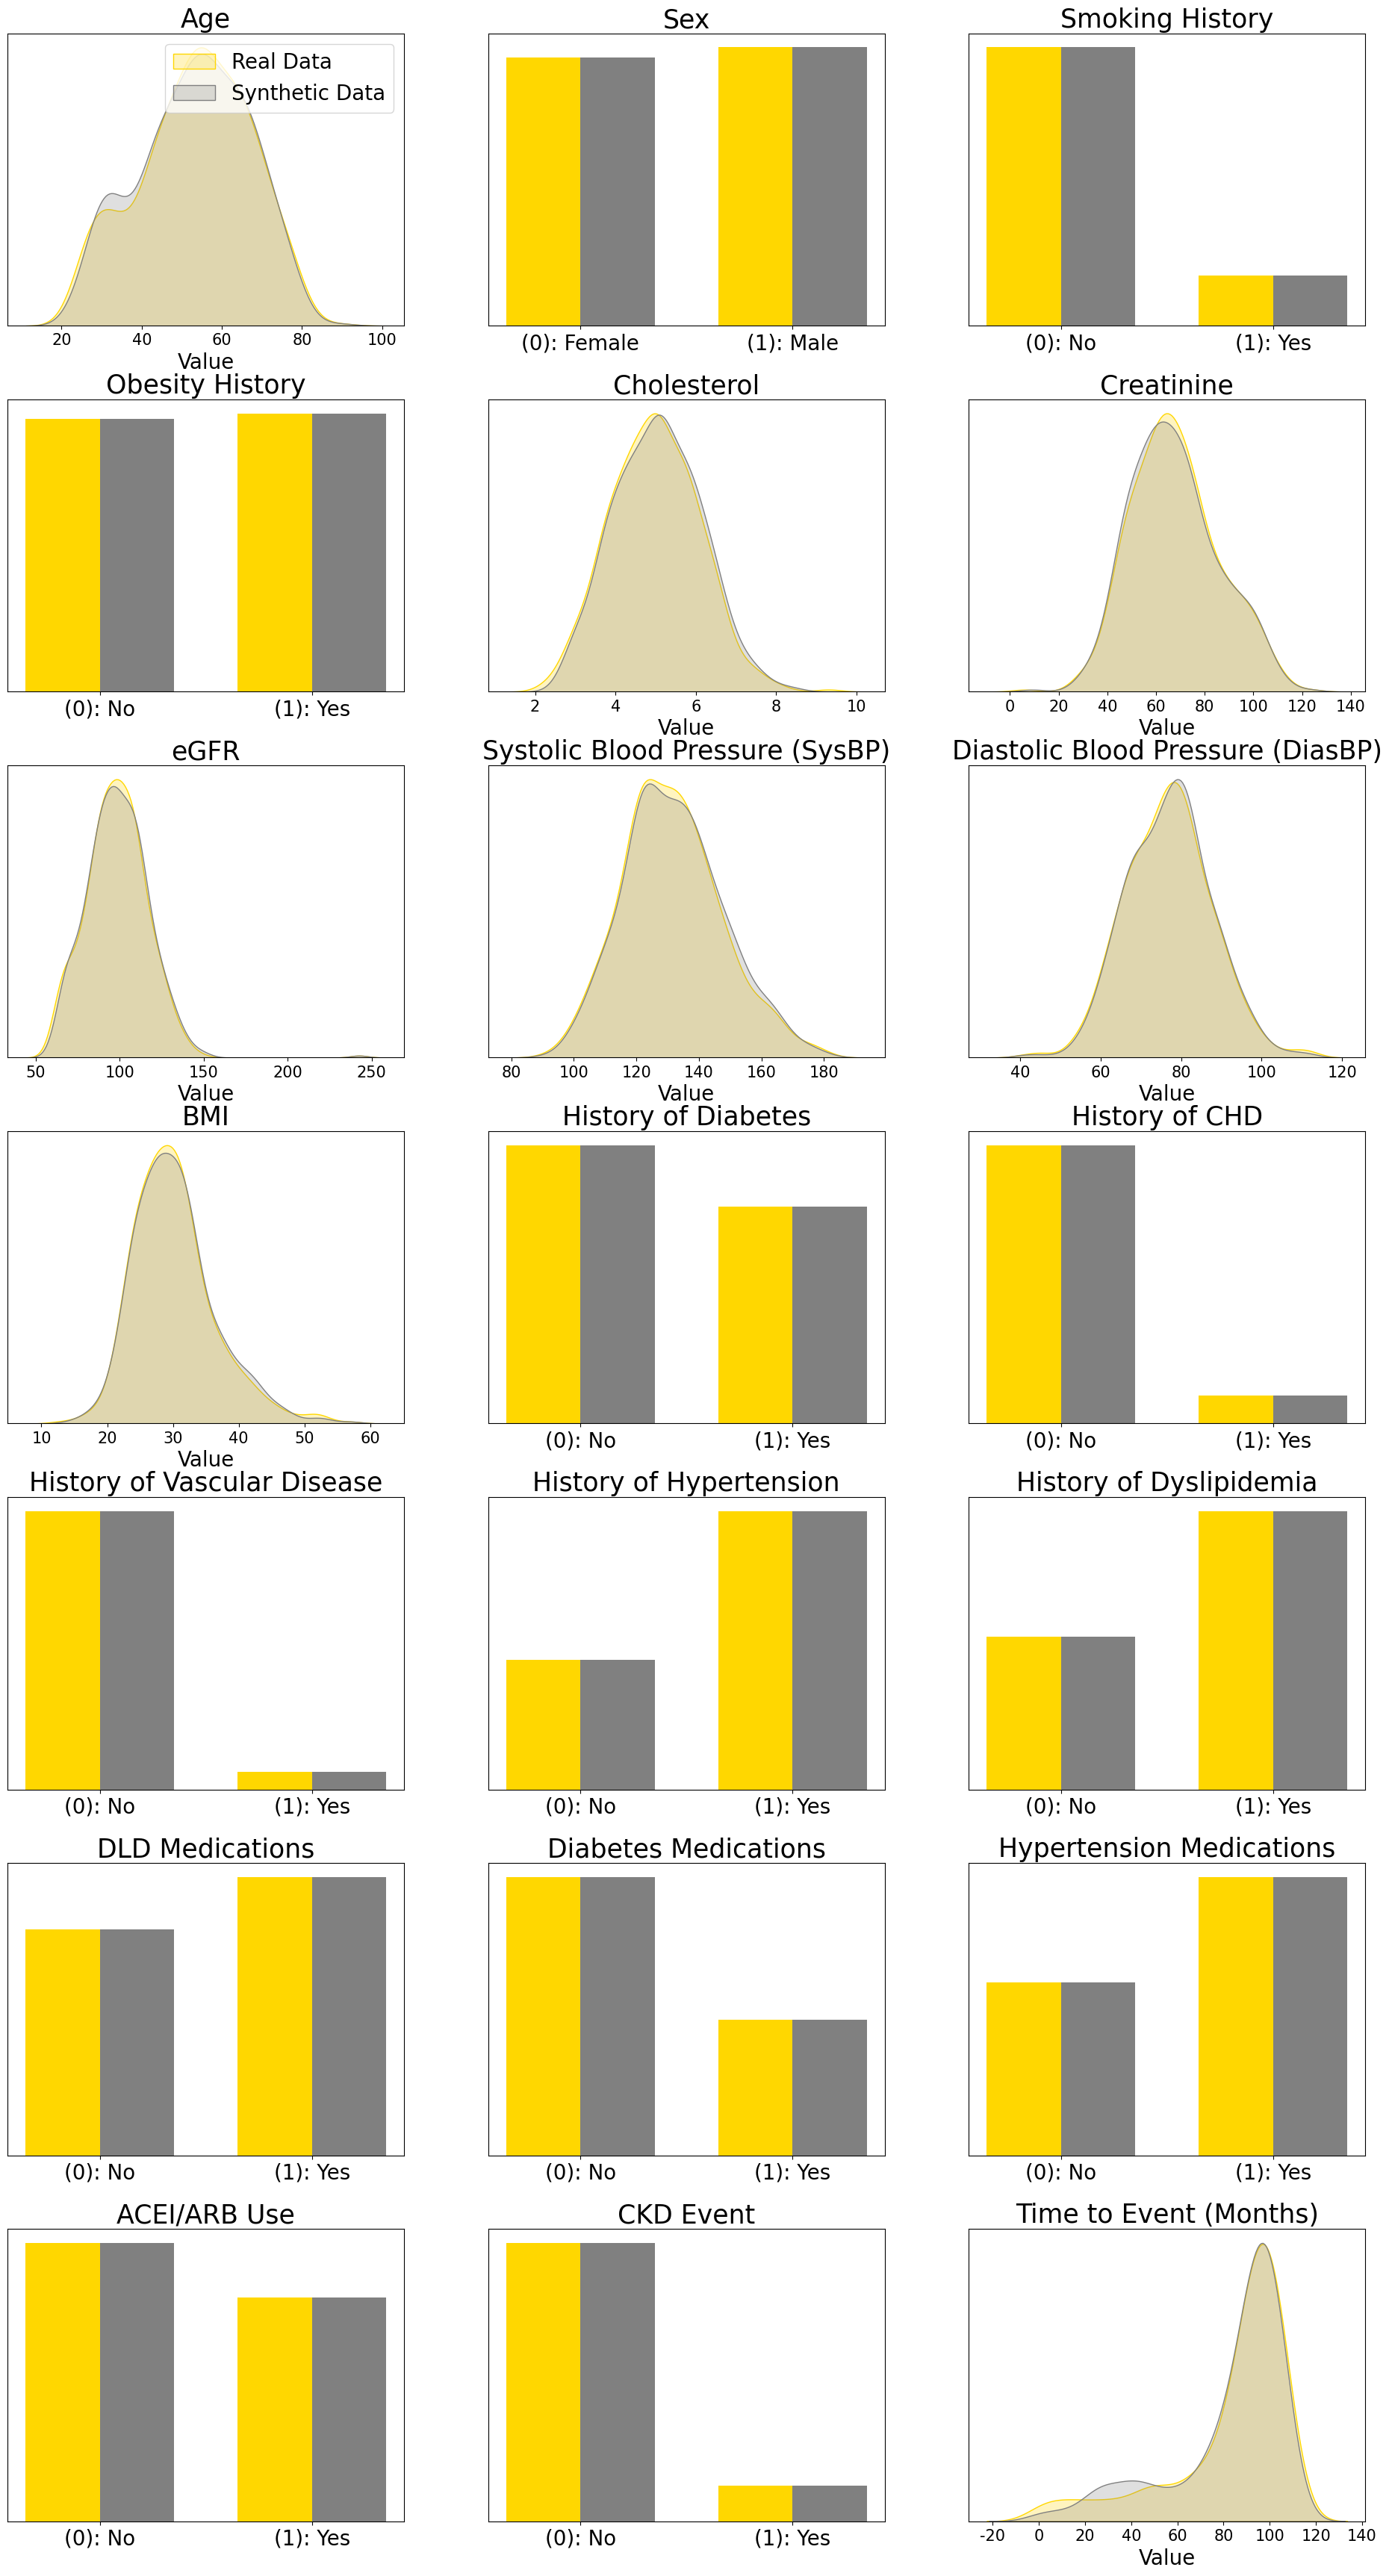

In [ ]:
seed_everything()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Update variable_mapping to include all columns with titles, types, and xtick labels where appropriate
variable_mapping = {
    # Demographic and Lifestyle Variables
    'DEM_Age': {'type': 'numeric', 'title': 'Age'},
    'DEM_Sex': {'type': 'binary', 'title': 'Sex', 'xticks': ['(0): Female', '(1): Male']},
    'DEM_Smoking_History': {'type': 'binary', 'title': 'Smoking History', 'xticks': ['(0): No', '(1): Yes']},
    'DEM_Obesity_History': {'type': 'binary', 'title': 'Obesity History', 'xticks': ['(0): No', '(1): Yes']},

    # Clinical Baseline Measurements
    'CBM_Cholesterol': {'type': 'numeric', 'title': 'Cholesterol'},
    'CBM_Creatinine': {'type': 'numeric', 'title': 'Creatinine'},
    'CBM_eGFR': {'type': 'numeric', 'title': 'eGFR'},
    'CBM_Systolic_BP': {'type': 'numeric', 'title': 'Systolic Blood Pressure (SysBP)'},
    'CBM_Diastolic_BP': {'type': 'numeric', 'title': 'Diastolic Blood Pressure (DiasBP)'},
    'CBM_BMI': {'type': 'numeric', 'title': 'BMI'},

    # Medical History Variables
    'MH_Diabetes_History': {'type': 'binary', 'title': 'History of Diabetes', 'xticks': ['(0): No', '(1): Yes']},
    'MH_CHD_History': {'type': 'binary', 'title': 'History of CHD', 'xticks': ['(0): No', '(1): Yes']},
    'MH_Vascular_History': {'type': 'binary', 'title': 'History of Vascular Disease', 'xticks': ['(0): No', '(1): Yes']},
    'MH_Hypertension_History': {'type': 'binary', 'title': 'History of Hypertension', 'xticks': ['(0): No', '(1): Yes']},
    'MH_Dyslipidemia_History': {'type': 'binary', 'title': 'History of Dyslipidemia', 'xticks': ['(0): No', '(1): Yes']},

    # Medication Use Variables
    'MED_DLD_Meds': {'type': 'binary', 'title': 'DLD Medications', 'xticks': ['(0): No', '(1): Yes']},
    'MED_Diabetes_Meds': {'type': 'binary', 'title': 'Diabetes Medications', 'xticks': ['(0): No', '(1): Yes']},
    'MED_HTN_Meds': {'type': 'binary', 'title': 'Hypertension Medications', 'xticks': ['(0): No', '(1): Yes']},
    'MED_ACEI_ARB_Use': {'type': 'binary', 'title': 'ACEI/ARB Use', 'xticks': ['(0): No', '(1): Yes']},

    # Outcome Variables
    'OUT_EventCKD35': {'type': 'binary', 'title': 'CKD Event', 'xticks': ['(0): No', '(1): Yes']},
    'OUT_TimeToEventMonths': {'type': 'numeric', 'title': 'Time to Event (Months)'}
}

# Number of subplots based on the number of variables
num_vars = len(variable_mapping)
ncols = 3
nrows = int(np.ceil(num_vars / ncols))

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
fig.tight_layout(pad=5.0)
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, (col, info) in enumerate(variable_mapping.items()):
    ax = axes[i]

    if info['type'] == 'binary':
        # Calculate proportions for 0 and 1 in both datasets
        real_counts = my_df[col].value_counts(normalize=True).sort_index()
        fake_counts = synth_data_df[col].value_counts(normalize=True).sort_index()

        # Align proportions for 0 and 1, filling missing values with 0
        real_counts = real_counts.reindex([0, 1], fill_value=0)
        fake_counts = fake_counts.reindex([0, 1], fill_value=0)

        # Define positions for side-by-side bars
        bar_width = 0.35
        index = np.arange(len(real_counts))

        # Bar plots for real and synthetic data
        ax.bar(index, real_counts, bar_width, label='Real Data', color='gold')
        ax.bar(index + bar_width, fake_counts, bar_width, label='Synthetic Data', color='grey')

        # Set titles and labels
        ax.set_title(info['title'], fontsize=25)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(info['xticks'], fontsize=20)

        # Hide y-ticks and y-labels
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')

        # Show legend only for the first plot
        if i == 0:
            ax.legend(loc='upper right', fontsize=20)

    elif info['type'] == 'numeric':
        # KDE plot for numeric data
        sns.kdeplot(my_df[col], ax=ax, label='Real Data', color='gold', fill=True, common_norm=False)
        sns.kdeplot(synth_data_df[col], ax=ax, label='Synthetic Data', color='grey', fill=True, common_norm=False)

        # Set titles and labels
        ax.set_title(info['title'], fontsize=25)
        ax.set_xlabel('Value', fontsize=20)
        ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=15)

        # Hide y-ticks and y-labels
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')

        # Show legend only for the first plot
        if i == 0:
            ax.legend(loc='upper right', fontsize=20)
        else:
            ax.legend().set_visible(False)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plots
plt.show()


<ipython-input-38-6a7e765babc3>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


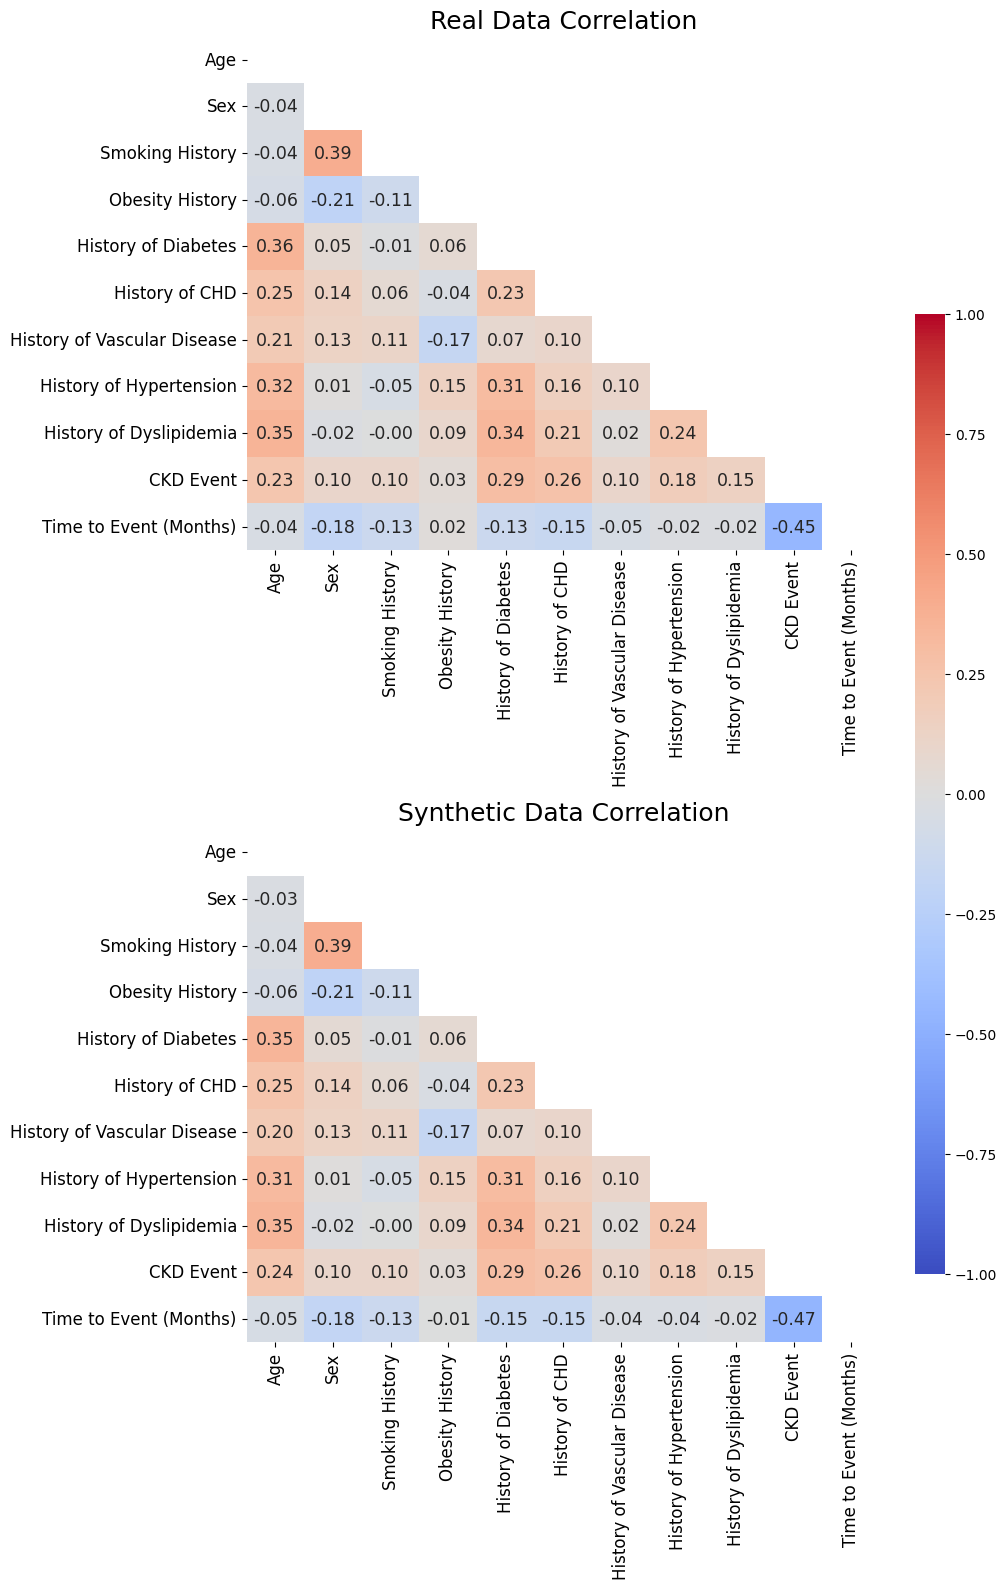

In [ ]:
seed_everything()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

real_df = copy.copy(my_df)
fake_df = copy.copy(synth_data_df)

# Define column mapping and list of columns to exclude
variable_mapping = {
    'DEM_Age': 'Age',
    'DEM_Sex': 'Sex',
    'DEM_Smoking_History': 'Smoking History',
    'DEM_Obesity_History': 'Obesity History',
    'CBM_Cholesterol': 'Cholesterol',
    'CBM_Creatinine': 'Creatinine',
    'CBM_eGFR': 'eGFR',
    'CBM_Systolic_BP': 'Systolic Blood Pressure (SysBP)',
    'CBM_Diastolic_BP': 'Diastolic Blood Pressure (DiasBP)',
    'CBM_BMI': 'BMI',
    'MH_Diabetes_History': 'History of Diabetes',
    'MH_CHD_History': 'History of CHD',
    'MH_Vascular_History': 'History of Vascular Disease',
    'MH_Hypertension_History': 'History of Hypertension',
    'MH_Dyslipidemia_History': 'History of Dyslipidemia',
    'MED_DLD_Meds': 'DLD Medications',
    'MED_Diabetes_Meds': 'Diabetes Medications',
    'MED_HTN_Meds': 'Hypertension Medications',
    'MED_ACEI_ARB_Use': 'ACEI/ARB Use',
    'OUT_EventCKD35': 'CKD Event',
    'OUT_TimeToEventMonths': 'Time to Event (Months)'
}

# Directly rename columns in real and synthetic data using variable_mapping
real_df = real_df.rename(columns=variable_mapping)
fake_df = fake_df.rename(columns=variable_mapping)

# Now define columns_to_compare based on the new column names that are present in variable_mapping values
columns_to_compare = [col for col in variable_mapping.values() if col in real_df.columns]

# Compute correlation matrices with the renamed columns
corr_real = real_df[columns_to_compare].corr()
corr_synth = fake_df[columns_to_compare].corr()

subset_columns = [key for key in variable_mapping if key.startswith('DEM') or key.startswith('OUT') or key.startswith('MH')]
subset_columns_mapped = [variable_mapping[col] for col in subset_columns]


# Filter correlation matrices to show only the subset of DEM, OUT, and MH variables
subset_columns_mapped = [variable_mapping[col] for col in subset_columns]
corr_real_subset = corr_real.loc[subset_columns_mapped, subset_columns_mapped]
corr_synth_subset = corr_synth.loc[subset_columns_mapped, subset_columns_mapped]

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_real_subset, dtype=bool))

# Plot vertically stacked heatmaps with simpler titles
fig, axes = plt.subplots(nrows=2, figsize=(10, 16))

# Heatmap for the real data correlations (without color bar)
sns.heatmap(corr_real_subset, ax=axes[0], cmap='coolwarm', annot=True, fmt=".2f", cbar=False, mask=mask, vmin=-1, vmax=1, annot_kws={"fontsize": 12.5})
axes[0].set_title('Real Data Correlation', fontsize=18)

# Heatmap for the synthetic data correlations with adjusted color bar
cbar_ax = fig.add_axes([.92, .2, .03, .6])  # Adjust color bar position for vertical stacking
sns.heatmap(corr_synth_subset, ax=axes[1], cmap='coolwarm', annot=True, fmt=".2f", cbar_ax=cbar_ax, mask=mask, vmin=-1, vmax=1, annot_kws={"fontsize": 12.5})
axes[1].set_title('Synthetic Data Correlation', fontsize=18)

# Set x-ticks and y-ticks without rotation
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

# Adjust layout to accommodate the color bar
plt.tight_layout(rect=[0, 0, .9, 1])
plt.show()


<ipython-input-39-3c3b091c9066>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


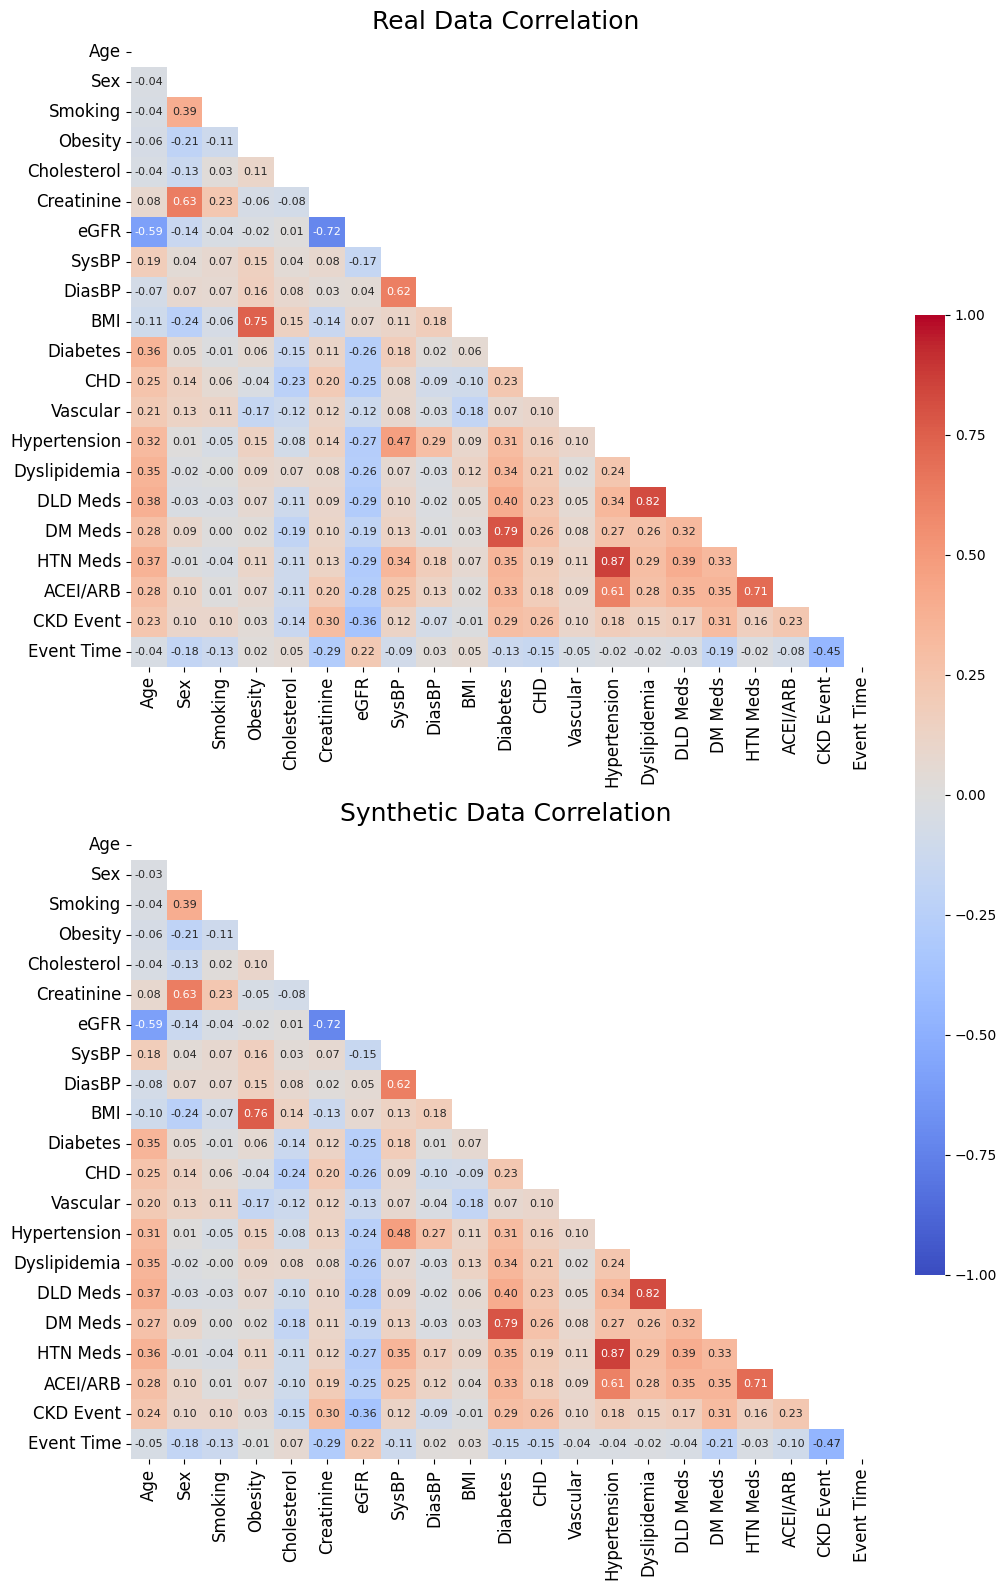

In [ ]:
seed_everything()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your datasets are loaded as DataFrames
# my_df = pd.read_csv('path_to_my_df.csv')
# synth_data_df = pd.read_csv('path_to_synth_data_df.csv')

# Exclude 'Event' and 'Duration' columns if present
columns_to_compare = [col for col in my_df.columns if col not in ['Event', 'Duration']]

# Compute correlation matrices
corr_real = my_df[columns_to_compare].corr()
corr_synth = synth_data_df[columns_to_compare].corr()

# Mapping of column names to shortened and meaningful titles
simplified_variable_mapping = {
    'DEM_Age': 'Age',
    'DEM_Sex': 'Sex',
    'DEM_Smoking_History': 'Smoking',
    'DEM_Obesity_History': 'Obesity',
    'CBM_Cholesterol': 'Cholesterol',
    'CBM_Creatinine': 'Creatinine',
    'CBM_eGFR': 'eGFR',
    'CBM_Systolic_BP': 'SysBP',
    'CBM_Diastolic_BP': 'DiasBP',
    'CBM_BMI': 'BMI',
    'MH_Diabetes_History': 'Diabetes',
    'MH_CHD_History': 'CHD',
    'MH_Vascular_History': 'Vascular',
    'MH_Hypertension_History': 'Hypertension',
    'MH_Dyslipidemia_History': 'Dyslipidemia',
    'MED_DLD_Meds': 'DLD Meds',
    'MED_Diabetes_Meds': 'DM Meds',
    'MED_HTN_Meds': 'HTN Meds',
    'MED_ACEI_ARB_Use': 'ACEI/ARB',
    'OUT_EventCKD35': 'CKD Event',
    'OUT_TimeToEventMonths': 'Event Time'
}

# Replace column names with shortened titles
corr_real.rename(columns=simplified_variable_mapping, index=simplified_variable_mapping, inplace=True)
corr_synth.rename(columns=simplified_variable_mapping, index=simplified_variable_mapping, inplace=True)

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_real, dtype=bool))


# Adjusting the code to display correlation heatmaps vertically and with simplified titles

# Plot vertically stacked heatmaps with simpler titles
fig, axes = plt.subplots(nrows=2, figsize=(10, 16))

# Heatmap for the real data correlations (without color bar)
sns.heatmap(corr_real, ax=axes[0], cmap='coolwarm', annot=True, fmt=".2f", cbar=False, mask=mask, vmin=-1, vmax=1, annot_kws={"fontsize": 8})
axes[0].set_title('Real Data Correlation', fontsize=18)

# Heatmap for the synthetic data correlations with adjusted color bar
cbar_ax = fig.add_axes([.92, .2, .03, .6])  # Adjust color bar position for vertical stacking
sns.heatmap(corr_synth, ax=axes[1], cmap='coolwarm', annot=True, fmt=".2f", cbar_ax=cbar_ax, mask=mask, vmin=-1, vmax=1, annot_kws={"fontsize": 8})
axes[1].set_title('Synthetic Data Correlation', fontsize=18)

# Set x-ticks and y-ticks without rotation
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

# Adjust layout to accommodate the color bar
plt.tight_layout(rect=[0, 0, .9, 1])
plt.show()


In [ ]:
my_df.columns

Index(['DEM_Age', 'DEM_Sex', 'DEM_Smoking_History', 'DEM_Obesity_History',
       'CBM_Cholesterol', 'CBM_Creatinine', 'CBM_eGFR', 'CBM_Systolic_BP',
       'CBM_Diastolic_BP', 'CBM_BMI', 'MH_Diabetes_History', 'MH_CHD_History',
       'MH_Vascular_History', 'MH_Hypertension_History',
       'MH_Dyslipidemia_History', 'MED_DLD_Meds', 'MED_Diabetes_Meds',
       'MED_HTN_Meds', 'MED_ACEI_ARB_Use', 'OUT_EventCKD35',
       'OUT_TimeToEventMonths'],
      dtype='object')

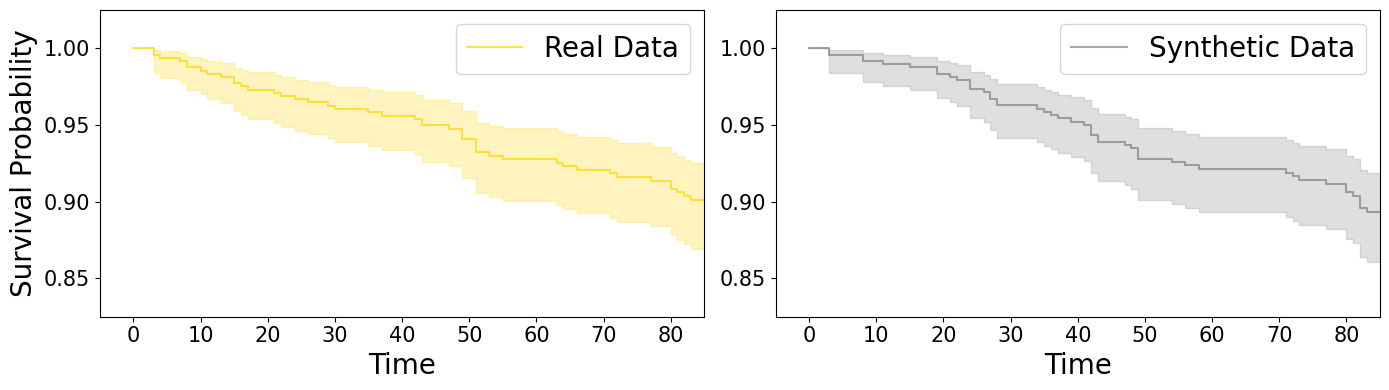

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Assuming your datasets are loaded as DataFrames
# my_df = pd.read_csv('path_to_my_df.csv')
# synth_data_df = pd.read_csv('path_to_synth_data_df.csv')

# Initialize the Kaplan-Meier fitter
kmf_real = KaplanMeierFitter()
kmf_synth = KaplanMeierFitter()

# Fit the model for real data
kmf_real.fit(durations=my_df['OUT_TimeToEventMonths'],
             event_observed=my_df['OUT_EventCKD35'], label='Real Data')

# Fit the model for synthetic data
kmf_synth.fit(durations=synth_data_df['OUT_TimeToEventMonths'],
              event_observed=synth_data_df['OUT_EventCKD35'], label='Synthetic Data')

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

# Plot the survival curve for the real data on the first subplot
kmf_real.plot_survival_function(ax=axes[0], ci_show=True, color='gold', alpha=0.7)
axes[0].set_xlabel('Time', fontsize=20)
axes[0].set_ylabel('Survival Probability', fontsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].legend(fontsize=20)
axes[0].set_ylim([0.825, 1.025])
axes[0].set_xlim([-5, 85])

# Plot the survival curve for the synthetic data on the second subplot
kmf_synth.plot_survival_function(ax=axes[1], ci_show=True, color='grey', alpha=0.7)
axes[1].set_xlabel('Time', fontsize=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].legend(fontsize=20)
axes[1].set_ylim([0.825, 1.025])
axes[1].set_xlim([-5, 85])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


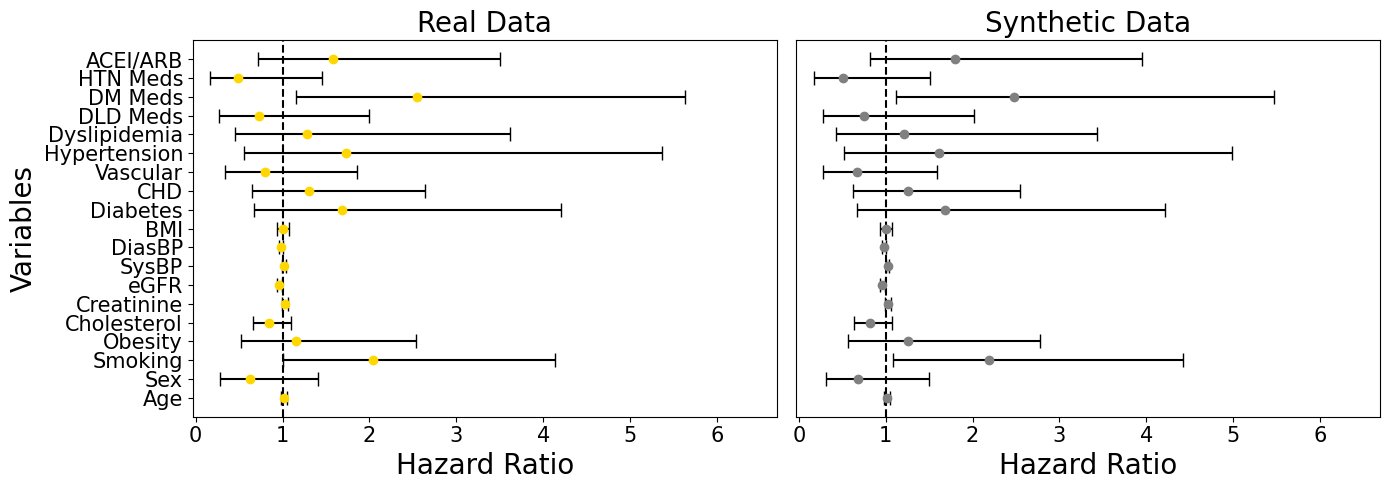

In [ ]:
seed_everything()

import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import numpy as np

real_df = copy.copy(my_df)
fake_df = copy.copy(synth_data_df)

# Assuming your datasets are loaded as DataFrames
# my_df = pd.read_csv('path_to_my_df.csv')
# synth_data_df = pd.read_csv('path_to_synth_data_df.csv')

# Define clinically meaningful short descriptions
simplified_variable_mapping = {
    'DEM_Age': 'Age',
    'DEM_Sex': 'Sex',
    'DEM_Smoking_History': 'Smoking',
    'DEM_Obesity_History': 'Obesity',
    'CBM_Cholesterol': 'Cholesterol',
    'CBM_Creatinine': 'Creatinine',
    'CBM_eGFR': 'eGFR',
    'CBM_Systolic_BP': 'SysBP',
    'CBM_Diastolic_BP': 'DiasBP',
    'CBM_BMI': 'BMI',
    'MH_Diabetes_History': 'Diabetes',
    'MH_CHD_History': 'CHD',
    'MH_Vascular_History': 'Vascular',
    'MH_Hypertension_History': 'Hypertension',
    'MH_Dyslipidemia_History': 'Dyslipidemia',
    'MED_DLD_Meds': 'DLD Meds',
    'MED_Diabetes_Meds': 'DM Meds',
    'MED_HTN_Meds': 'HTN Meds',
    'MED_ACEI_ARB_Use': 'ACEI/ARB',
    'OUT_EventCKD35': 'CKD Event',
    'OUT_TimeToEventMonths': 'Event Time'
}

# Rename the columns in both datasets using the variable_mapping
real_df.rename(columns=simplified_variable_mapping, inplace=True)
fake_df.rename(columns=simplified_variable_mapping, inplace=True)

# Initialize the Cox Proportional Hazards model
cph_real = CoxPHFitter(penalizer = 0.01)
cph_synth = CoxPHFitter(penalizer = 0.01)

# Fit the CoxPH model on the real data
cph_real.fit(real_df, duration_col='Event Time', event_col='CKD Event')

# Fit the CoxPH model on the synthetic data
cph_synth.fit(fake_df, duration_col='Event Time', event_col='CKD Event')

# Extract Hazard Ratios and Confidence Intervals from the summary
hr_real = cph_real.summary['exp(coef)']
ci_real_lower = cph_real.summary['exp(coef) lower 95%']
ci_real_upper = cph_real.summary['exp(coef) upper 95%']

hr_synth = cph_synth.summary['exp(coef)']
ci_synth_lower = cph_synth.summary['exp(coef) lower 95%']
ci_synth_upper = cph_synth.summary['exp(coef) upper 95%']

# Calculate the error bars for HRs
hr_real_lower_err = abs(hr_real - ci_real_lower)
hr_real_upper_err = abs(ci_real_upper - hr_real)

hr_synth_lower_err = abs(hr_synth - ci_synth_lower)
hr_synth_upper_err = abs(ci_synth_upper - hr_synth)

# Ensure the error arrays are correctly shaped
xerr_real = np.array([hr_real_lower_err.values, hr_real_upper_err.values])
xerr_synth = np.array([hr_synth_lower_err.values, hr_synth_upper_err.values])

# Determine the common xlim and ylim for both plots
xlim = (min(hr_real.min() - hr_real_lower_err.min(), hr_synth.min() - hr_synth_lower_err.min()) - 0.5,
        max(hr_real.max() + hr_real_upper_err.max(), hr_synth.max() + hr_synth_upper_err.max()) + 0.5)

ylim = (-1, len(hr_real))

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

# Plot HRs and 95% CI for real data
axes[0].errorbar(hr_real, hr_real.index,
                 xerr=xerr_real,
                 fmt='o', color='gold', ecolor='black', capsize=5, label='HR (95% CI)')
axes[0].axvline(x=1, color='black', linestyle='--')
axes[0].set_title('Real Data', fontsize=20)
axes[0].set_xlabel('Hazard Ratio', fontsize=20)
axes[0].set_ylabel('Variables', fontsize=20)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# Plot HRs and 95% CI for synthetic data
axes[1].errorbar(hr_synth, hr_synth.index,
                 xerr=xerr_synth,
                 fmt='o', color='grey', ecolor='black', capsize=5, label='HR (95% CI)')
axes[1].axvline(x=1, color='black', linestyle='--')
axes[1].set_title('Synthetic Data', fontsize=20)
axes[1].set_xlabel('Hazard Ratio', fontsize=20)
axes[1].set_ylabel('')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# Remove y-ticks from the right subplot
axes[1].yaxis.set_ticks([])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
